In [ ]:
!pip install pyro-ppl

In [103]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


import time

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df=df.drop('HourUTC', axis=1)
df=df.drop('PriceArea', axis=1)
df['hour'] = df['HourDK'].dt.hour
df.columns


df_use=df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m',
       'cloud_cover', 'hourly_wind_speed_10m','hour']]
df_use
#'Hydro','Unknown_Production',
       # 'ExchangeGreatBelt_MWh', 'Exchange', 'GridLoss' , 'SpotPriceEUR', 'precipitation',

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m,hour
1,2022-01-01 00:00:00,1114.281163,0.022679,789.892353,1415.517875,346.540009,7.0,100,4.14,0
3,2022-01-01 01:00:00,1206.825676,0.022142,644.458331,1394.053760,307.350006,7.4,100,4.10,1
5,2022-01-01 02:00:00,1215.685368,0.020423,599.437590,1342.593361,313.670013,6.9,100,3.98,2
7,2022-01-01 03:00:00,1070.803483,0.024189,624.804126,1292.604709,329.959991,6.6,100,3.57,3
9,2022-01-01 04:00:00,899.497269,0.019869,650.523492,1261.550580,280.130005,6.7,100,3.01,4
...,...,...,...,...,...,...,...,...,...,...
37911,2024-02-29 19:00:00,1269.406780,0.603984,692.384290,1950.231822,402.510010,7.0,100,4.73,19
37913,2024-02-29 20:00:00,1295.941996,0.462586,699.232854,1856.984338,216.910004,6.8,100,4.74,20
37915,2024-02-29 21:00:00,1279.730675,0.429421,669.755253,1767.729341,186.720001,6.5,100,4.84,21
37916,2024-02-29 22:00:00,1233.604793,0.437171,605.839292,1654.056866,186.720001,6.5,100,4.82,22


In [104]:
# Calculate variance for cloud, solar, and wind
cloud_variance = df["cloud_cover"].var()
solar_variance = df["Solar"].var()
wind_variance = df["Wind"].var()

# Print the variances
print(f"Cloud cover variance: {cloud_variance:.0f}")
print(f"Solar generation variance: {solar_variance:.0f}")
print(f"Wind generation variance: {wind_variance:.0f}")

Cloud cover variance: 1483
Solar generation variance: 19066
Wind generation variance: 237211


# TRying a simple model

### Here we only take 4 days worth of data

In [105]:
import torch
import torch.nn as nn
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [106]:
# Load and preprocess data
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df.drop(columns=['HourUTC', 'PriceArea'])
df['hour'] = df['HourDK'].dt.hour
df['dayofweek'] = df['HourDK'].dt.weekday.astype(int)

df_use = df[['HourDK', 'Wind','SpotPriceDKK', 'Solar', 'Power', 'GrossConsumptionMWh',
             'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'hour','dayofweek']]
#  REMOVED SpotPriceDKK
# ADDED DAY OF WEEK

num_test_days = 50 #TODO CHANGE THIS
num_train_days = 10 #TODO CHANGE THIS!!!

start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) &
                        (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
                          'hourly_temperature_2m', 'cloud_cover']

scaler = MinMaxScaler()
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

X_train = torch.tensor(train_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
from pyro.nn import PyroModule, PyroSample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Assuming train_data and test_data are pandas DataFrames with columns specified
# Extract relevant columns
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover']].values
# X_train = train_data[[ 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values

y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover']].values
# X_test = test_data[['Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']].values

y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Define which columns are linear and nonlinear based on your dataset
# linear_stuff = [5, 6, 7]  # Example linear columns (indices)
# list_of_indexes = [0, 1, 2, 3, 4, 5, 6, 7]  # All possible columns in your dataset

# # Identify nonlinear columns by excluding linear columns
# non_linear_stuff = [x for x in list_of_indexes if x not in linear_stuff]

In [107]:
# Assuming df_use is your DataFrame containing the data
variance_temperature = df_use['hourly_temperature_2m'].var()
variance_cloud_cover = df_use['cloud_cover'].var()
variance_wind_speed = df_use['hourly_wind_speed_10m'].var()

print("Variance of Temperature:", variance_temperature)
print("Variance of Cloud Cover:", variance_cloud_cover)
print("Variance of Wind Speed:", variance_wind_speed)

Variance of Temperature: 44.08146685608273
Variance of Cloud Cover: 1482.9263884530535
Variance of Wind Speed: 4.23534777528591


In [108]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
from pyro.nn import PyroModule, PyroSample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# keep this stuff for now
# x_feat= ['HourDK', 'Wind', 'Solar', 'Power', 'SpotPriceDKK',
#                 'hourly_temperature_2m', 'cloud_cover', 'hour'] #'dayofweek'

# y_feat = ['GrossConsumptionMWh']

# X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = Load_dataset(x_feat, y_feat)

[0] ELBO: 54068.5
[1000] ELBO: 245.3
[2000] ELBO: 110.5
[3000] ELBO: -401.7
[4000] ELBO: -538.5
[5000] ELBO: -665.1


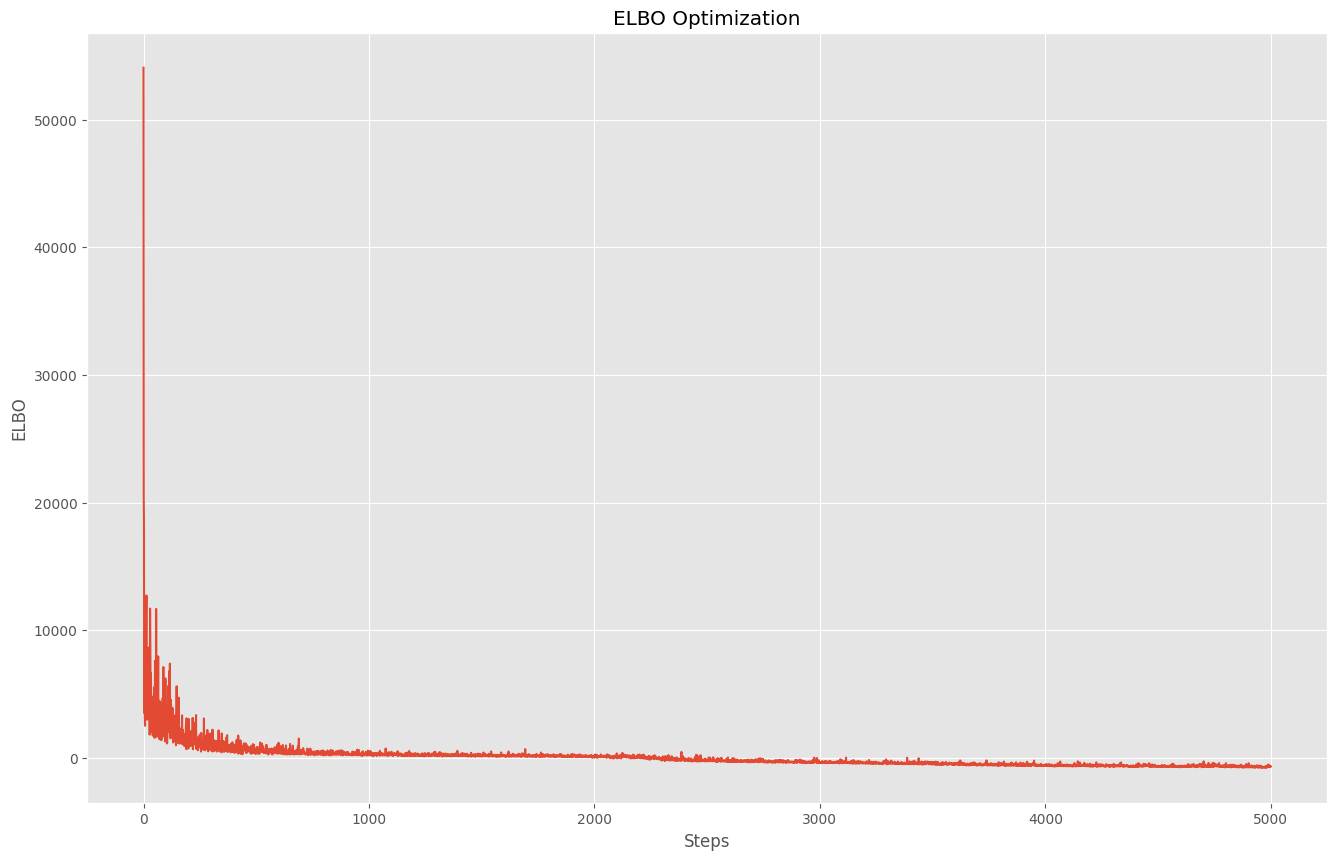

In [109]:
np.random.seed(42)
class BNN(PyroModule):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(BNN, self).__init__()

        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden1)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden1, n_in]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden1]).to_event(1))

        self.h_layer1 = PyroModule[nn.Linear](n_hidden1, n_hidden2)
        self.h_layer1.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden1]).to_event(2))
        self.h_layer1.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden2, n_hidden2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden2]).to_event(2))
        self.h_layer2.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.out_layer = PyroModule[nn.Linear](n_hidden2, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden2]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_out]).to_event(1))

        self.tanh = nn.Tanh()

    def forward(self, X, y=None):
        X_nn = self.tanh(self.in_layer(X))
        X_nn = self.tanh(self.h_layer1(X_nn))
        X_nn = self.tanh(self.h_layer2(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)

        with pyro.plate("observations", X.shape[0]):
            y = pyro.sample("obs", dist.Normal(nn_out, 0.1), obs=y)

        return nn_out

# Initialize the neural network model
input_dim =X_train.shape[1]  # Number of features (-1 for hourDK)
hidden_dim1 = 10  # Example first hidden layer dimension
hidden_dim2 = 10  # Example second hidden layer dimension
output_dim = 1  # Example output dimension (predicting one value)

model = BNN(n_in=input_dim, n_hidden1=hidden_dim1, n_hidden2=hidden_dim2, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)

# Number of optimization steps
n_steps = 5000

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo)
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()

In [110]:
def plot_forecast(obs_samples, dates, y_set, ylabel, title, train_test_split_date):
    #REMEMBER TO RE-WRITE THIS TODO
    y_mean = obs_samples.mean(axis=0).reshape(-1,)
    y_std = obs_samples.std(axis=0).reshape(-1,)

    forecast_plus_stddev = y_mean + 1.96 * y_std
    forecast_minus_stddev = y_mean - 1.96 * y_std

    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_set, "b-", label="True")
    plt.plot(dates, y_mean, "r-", label="Forecast")
    plt.fill_between(dates, forecast_minus_stddev, forecast_plus_stddev, color='r', alpha=0.15, label="Uncertainty")
    plt.axvline(x=train_test_split_date, color='green', linestyle=':', lw=3, label="Train-test split")
    plt.title(title, size=20)
    plt.xlabel("Time", size=15)
    plt.ylabel(ylabel, size=15)
    plt.legend(fontsize=13)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

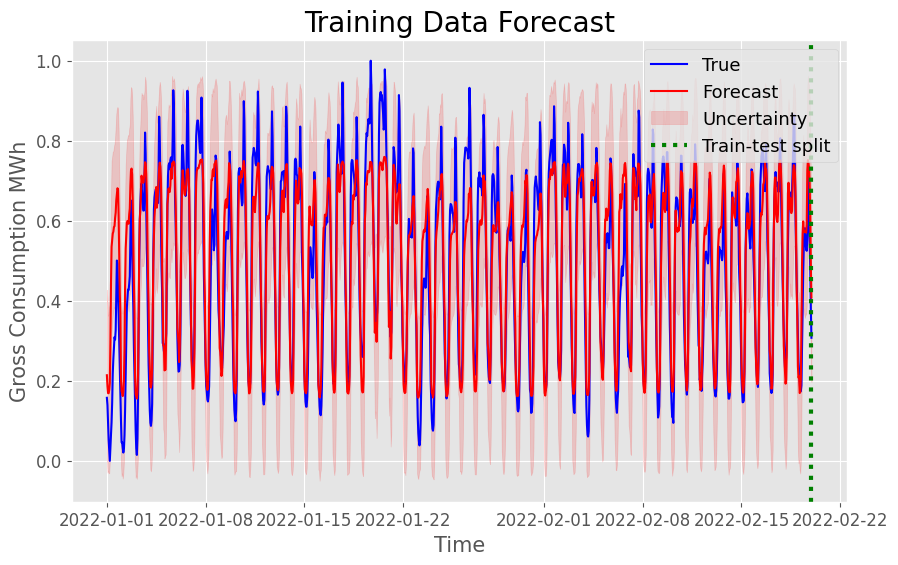

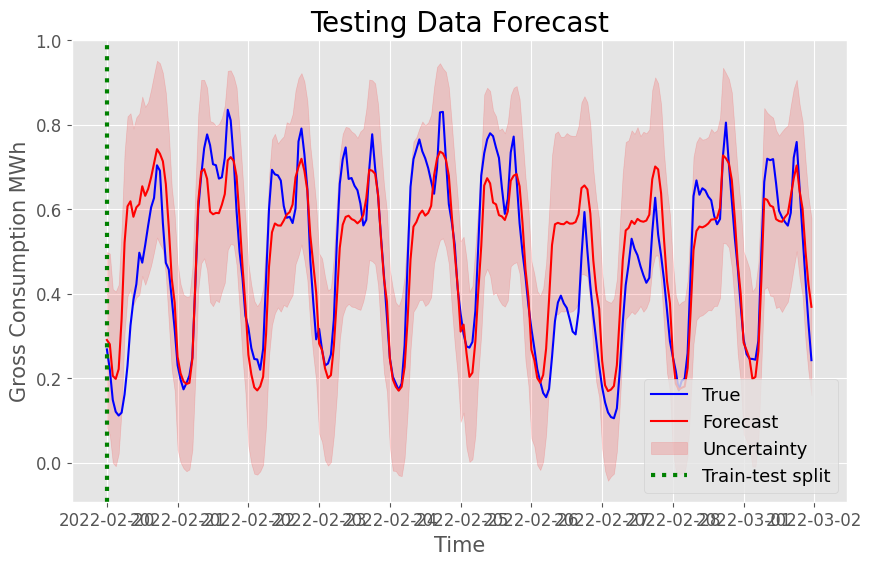

In [111]:
np.random.seed(42)
predictive = Predictive(model, guide=guide, num_samples=1000)

# Get predictions for training data
train_samples = predictive(X_train_tensor)
train_obs_samples = train_samples["obs"].detach().numpy()

# Get predictions for test data
test_samples = predictive(X_test_tensor)
test_obs_samples = test_samples["obs"].detach().numpy()

# Convert dates from your dataset for plotting
train_dates = pd.to_datetime(train_data['HourDK'])
test_dates = pd.to_datetime(test_data['HourDK'])

# Plot the training forecast
plot_forecast(train_obs_samples, train_dates, y_train, "Gross Consumption MWh", "Training Data Forecast", train_dates.iloc[-1])

# Plot the testing forecast
plot_forecast(test_obs_samples, test_dates, y_test, "Gross Consumption MWh", "Testing Data Forecast", test_dates.iloc[0])


Mean Absolute Error (MAE): 0.0804
Mean Squared Error (MSE): 0.0109
Mean Percentage Error (MPE): 9.1438%


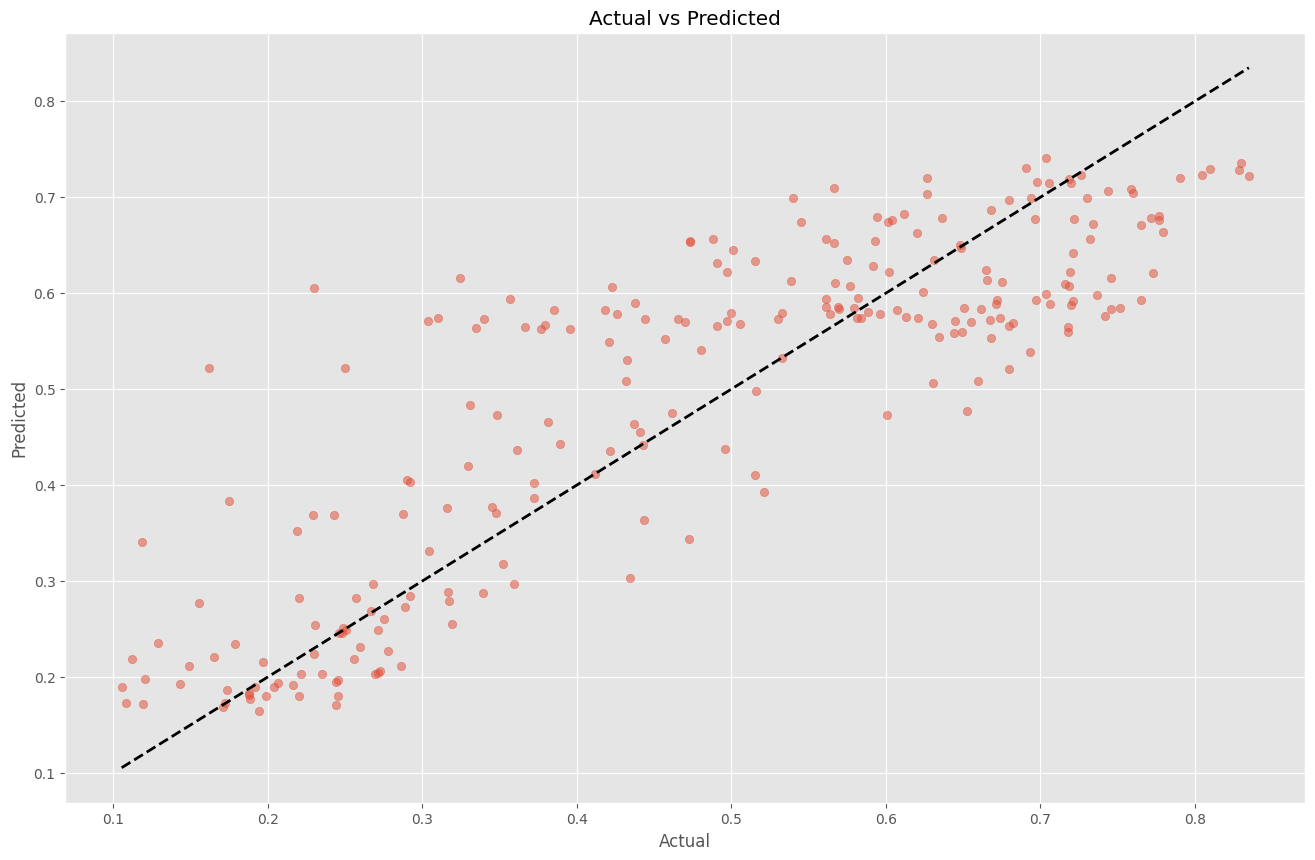

In [112]:
np.random.seed(42)
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X_test_tensor)

# Calculate mean predictions
y_pred = samples["obs"].mean(dim=0).detach().numpy()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Calculate Mean Percentage Error (MPE)
mpe = abs(np.mean((y_test - y_pred) / y_test) * 100)
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Notable, there are quite a few datapoints centered around ~0.2 and ~0.8. This is not unexpected as alot of the data is centered around these points. As can be seen in the XX graph. Most of the data either lies during period of high demand (during the day) or in period of low demand (during the night).

### STUFF Below this is draft and kinda iffy -- skip to heiarchical stuff

# HEIARCHICAL PART

### Could try a deep ensemble model?

!!! IMPORTANT !!!!

IF YOU WANT TO CHANGE THE INPUT FEATURES YOU NEED TO CHANGE THIS VECTOR EVERYWHERE (4 PLACES (3 Excluding the standardizatoin)):

['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover','is_weekend']

In [113]:
# Load and preprocess data
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df.drop(columns=['HourUTC', 'PriceArea'])
df['hour'] = df['HourDK'].dt.hour
df['dayofweek'] = df['HourDK'].dt.weekday


df_use = df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh', 'SpotPriceDKK',
             'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'hour','dayofweek']]

             ### REMVOED WIND SPEED
            ### IGNORE dayofweek
            ## REMOVE PRICE


num_test_days = 50 #TODO CHANGE THIS
num_train_days = 10 #TODO CHANGE THIS!!!

start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) &
                        (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh', 'SpotPriceDKK',
                          'hourly_temperature_2m', 'cloud_cover']

scaler = MinMaxScaler()
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

X_train = torch.tensor(train_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)


In [114]:
# Add 'day_of_week' and 'is_weekend' features
train_data['day_of_week'] = train_data['HourDK'].dt.dayofweek
train_data['is_weekend'] = train_data['day_of_week'] >= 5  # 0 is Monday, 6 is Sunday

test_data['day_of_week'] = test_data['HourDK'].dt.dayofweek
test_data['is_weekend'] = test_data['day_of_week'] >= 5

# Convert 'is_weekend' to int
train_data['is_weekend'] = train_data['is_weekend'].astype(int)
test_data['is_weekend'] = test_data['is_weekend'].astype(int)

# X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'is_weekend']].values
#X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover','is_weekend']].values
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover','is_weekend']].values


y_train = train_data['GrossConsumptionMWh'].values

# X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m', 'is_weekend']].values
#X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover','is_weekend']].values
X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover', 'is_weekend']].values


y_test = test_data['GrossConsumptionMWh'].values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


### non-shit Heiarchical model

[0] ELBO: 77379.6
[1000] ELBO: 159.3
[2000] ELBO: -157.4
[3000] ELBO: -496.7
[4000] ELBO: -537.1
[5000] ELBO: -718.4


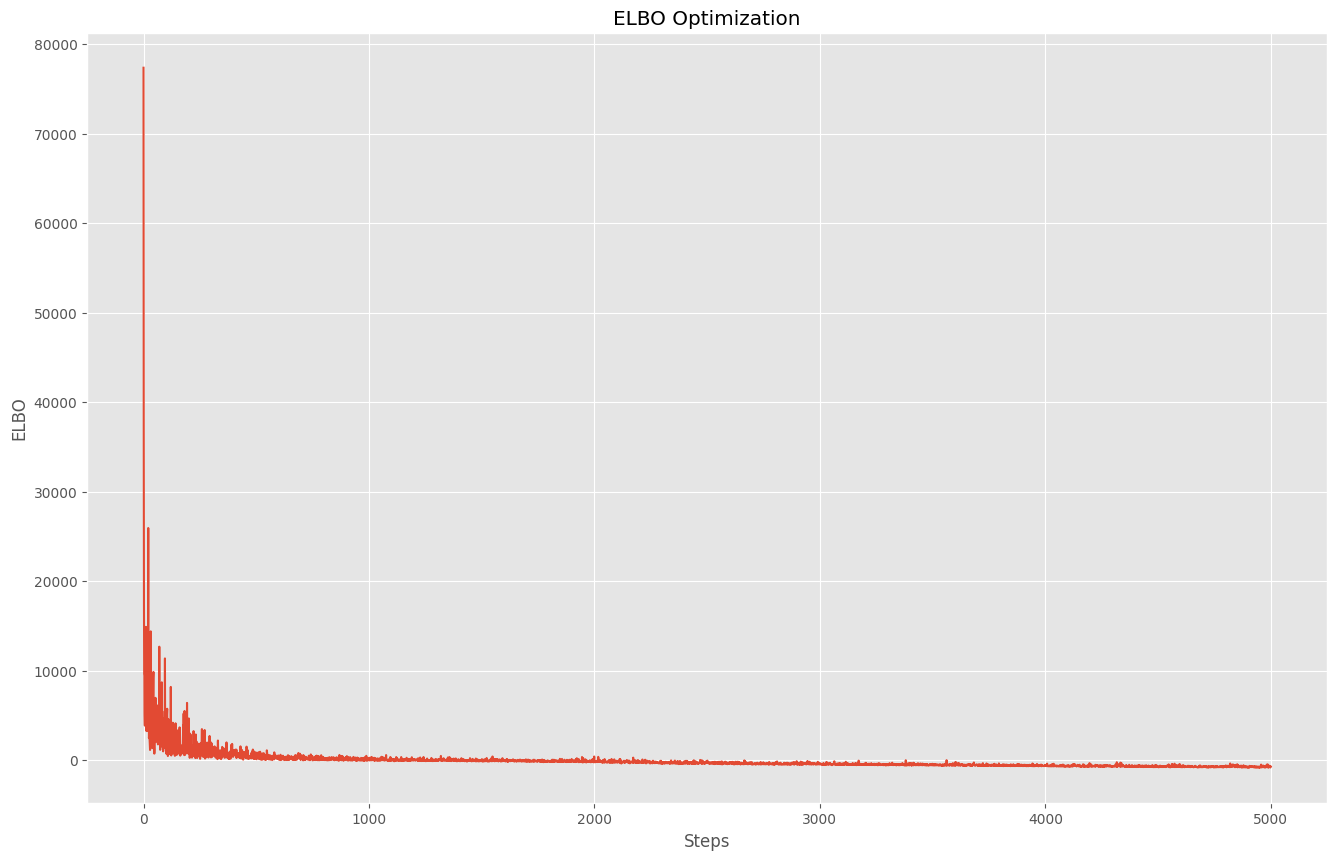

In [115]:
np.random.seed(42)
class HierarchicalBNN(PyroModule):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(HierarchicalBNN, self).__init__()

        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden1)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden1, n_in]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden1]).to_event(1))

        self.h_layer1 = PyroModule[nn.Linear](n_hidden1, n_hidden2)
        self.h_layer1.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden1]).to_event(2))
        self.h_layer1.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden2, n_hidden2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden2]).to_event(2))
        self.h_layer2.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.out_layer = PyroModule[nn.Linear](n_hidden2, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden2]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_out]).to_event(1))

        self.weekend_effects = PyroModule[nn.Embedding](2, n_out)
        self.weekend_effects.weight = PyroSample(dist.Normal(0., 1.).expand([2, n_out]).to_event(2))

        self.tanh = nn.Tanh()

    def forward(self, X, y=None):
        is_weekend = X[:, -1].long()  # is_weekend is the last column !!!! RMEMBER THIS!!!!!!
        X_nn = self.tanh(self.in_layer(X[:, :-1]))
        X_nn = self.tanh(self.h_layer1(X_nn))
        X_nn = self.tanh(self.h_layer2(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)
        weekend_effect = self.weekend_effects(is_weekend).squeeze(-1)

        with pyro.plate("observations", X.shape[0]):
            y = pyro.sample("obs", dist.Normal(nn_out + weekend_effect, 0.1), obs=y)

        return nn_out + weekend_effect

# Initialize the hierarchical BNN model
input_dim = X_train.shape[1] - 1   # Number of features excluding the is_weekend column
hidden_dim1 = 10  # Example first hidden layer dimension
hidden_dim2 = 10  # Example second hidden layer dimension
output_dim = 1  # Example output dimension (predicting one value)

model = HierarchicalBNN(n_in=input_dim, n_hidden1=hidden_dim1, n_hidden2=hidden_dim2, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)

# Number of optimization steps
n_steps = 5000

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo)
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()


Mean Absolute Error (MAE): 0.0637
Mean Squared Error (MSE): 0.0062
Mean Percentage Error (MPE): 3.6030%


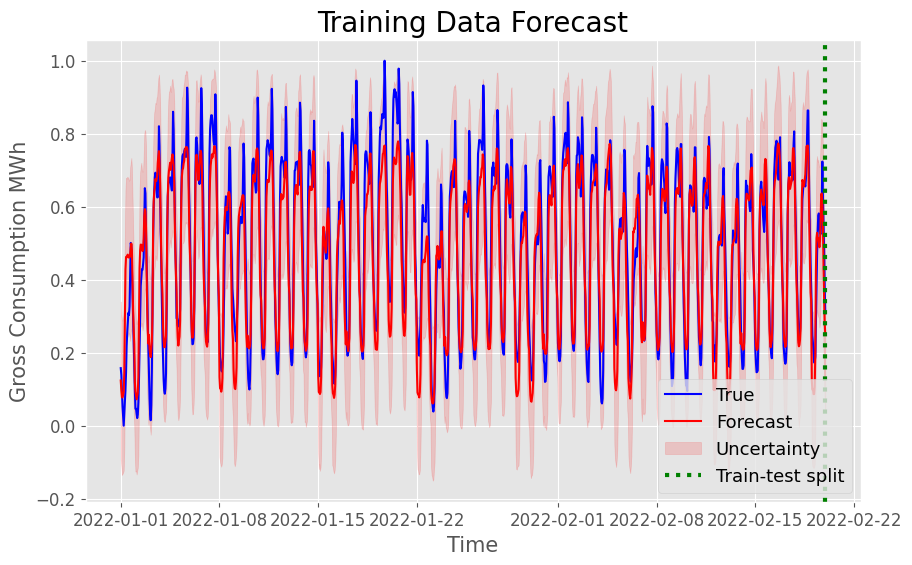

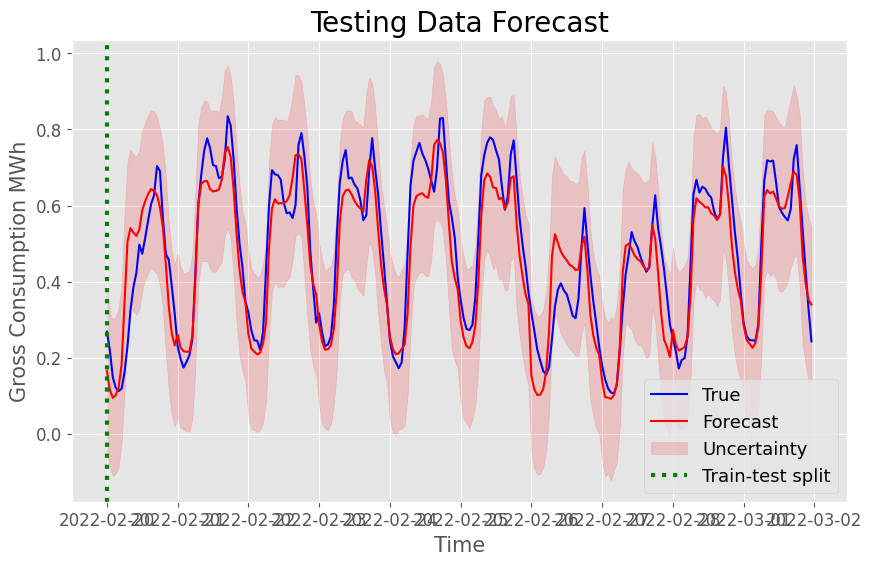

In [116]:
np.random.seed(42)
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X_test_tensor)

# Calculate mean predictions
y_pred = samples["obs"].mean(dim=0).detach().numpy()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Calculate Mean Percentage Error (MPE)
mpe = abs(np.mean((y_test - y_pred) / y_test) * 100)
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")



# Get predictions for training data
train_samples = predictive(X_train_tensor)
train_obs_samples = train_samples["obs"].detach().numpy()

# Get predictions for test data
test_samples = predictive(X_test_tensor)
test_obs_samples = test_samples["obs"].detach().numpy()

# Convert dates from your dataset for plotting
train_dates = pd.to_datetime(train_data['HourDK'])
test_dates = pd.to_datetime(test_data['HourDK'])

# Plot the training forecast
plot_forecast(train_obs_samples, train_dates, y_train, "Gross Consumption MWh", "Training Data Forecast", train_dates.iloc[-1])

# Plot the testing forecast
plot_forecast(test_obs_samples, test_dates, y_test, "Gross Consumption MWh", "Testing Data Forecast", test_dates.iloc[0])

